LOAD AND INSPECT DATA

In [4]:
import pandas as pd

df = pd.read_csv('/content/crop_yield_dataset.csv')
print(df)
df.head()
df.info()

        Crop    Region Soil_Type  Soil_pH  Rainfall_mm  Temperature_C  \
0      Maize  Region_C     Sandy     7.01       1485.4           19.7   
1     Barley  Region_D      Loam     5.79        399.4           29.1   
2       Rice  Region_C      Clay     7.24        980.9           30.5   
3      Maize  Region_D      Loam     6.79       1054.3           26.4   
4      Maize  Region_D     Sandy     5.96        744.6           20.4   
...      ...       ...       ...      ...          ...            ...   
9995  Barley  Region_A      Clay     5.84        890.4           28.5   
9996   Maize  Region_A     Sandy     6.91        614.2           30.0   
9997   Wheat  Region_A      Clay     6.98        842.0           22.6   
9998   Wheat  Region_D     Sandy     7.27        924.2           26.8   
9999    Rice  Region_C     Sandy     5.95        247.0           31.1   

      Humidity_pct  Fertilizer_Used_kg Irrigation  Pesticides_Used_kg  \
0             40.3               105.1       Drip 

In [2]:
df.describe()

,Soil_pH,Rainfall_mm,Temperature_C,Humidity_pct,Fertilizer_Used_kg,Pesticides_Used_kg,Planting_Density,Yield_ton_per_ha
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.516693,843.66467,24.975750,60.052550,175.083290,25.055500,14.997930,117.891105
std,0.574761,373.67076,5.790631,17.317097,71.964157,14.353483,5.833087,37.972664
min,5.500000,200.00000,15.000000,30.000000,50.000000,0.000000,5.000000,28.450000
25%,6.020000,518.00000,20.000000,45.100000,113.300000,12.600000,9.900000,87.135000
50%,6.520000,845.30000,24.900000,60.200000,175.000000,25.300000,15.000000,117.705000
75%,7.010000,1161.85000,30.100000,75.100000,237.900000,37.500000,20.100000,149.147500
max,7.500000,1499.70000,35.000000,90.000000,300.000000,50.000000,25.000000,207.210000


PRE PROCESS DATA

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Correctly drop both 'Region' and 'Irrigation' from the feature set X
X = df.drop(columns=["Region", "Irrigation"])
y = df["Irrigation"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

<Axes: xlabel='Temperature_C', ylabel='Density'>

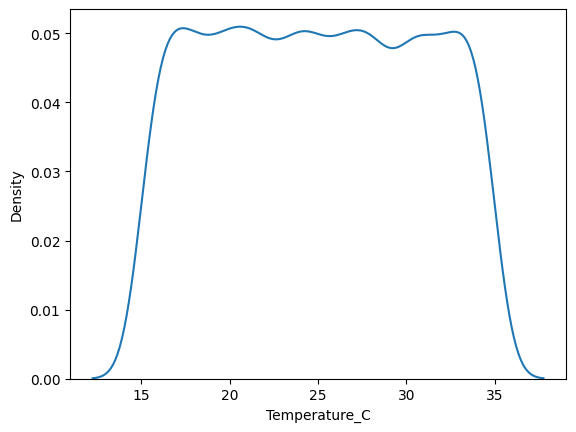

In [22]:
import seaborn as sns
sns.kdeplot(dt['Temperature_C'])

In [23]:
X.head()

,Crop,Region,Soil_Type,Soil_pH,Rainfall_mm,Temperature_C,Humidity_pct,Fertilizer_Used_kg,Pesticides_Used_kg,Planting_Density,Previous_Crop,Yield_ton_per_ha
0,1,2,2,7.01,1485.4,19.7,40.3,105.1,10.2,23.2,2,101.48
1,0,3,1,5.79,399.4,29.1,55.4,221.8,35.5,7.4,0,127.39
2,2,2,0,7.24,980.9,30.5,74.4,61.2,40.0,5.1,3,68.99
3,1,3,1,6.79,1054.3,26.4,62.0,257.8,42.7,23.7,4,169.06
4,1,3,2,5.96,744.6,20.4,70.9,195.8,25.5,15.6,1,118.71


TRAIN MODEL

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted') # Using weighted average for multiclass
    print(f"{name} Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

Logistic Regression Accuracy: 0.2455, F1-score: 0.2396
Random Forest Classifier Accuracy: 0.2585, F1-score: 0.2582
Gradient Boosting Classifier Accuracy: 0.2415, F1-score: 0.2404


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy') # Changed to Classifier and scoring='accuracy'
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_

Best Params: {'max_depth': 10, 'n_estimators': 100}


SAVE MODEL

In [26]:
import pickle
with open("crop_yield_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


MLOps Integration

In [36]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score

mlflow.start_run()
mlflow.log_params(grid.best_params_)

mlflow.log_metric("accuracy", accuracy_score(y_test, best_model.predict(X_test)))
mlflow.sklearn.log_model(best_model, "model")
mlflow.end_run()

2026/02/07 03:11:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


CHECKING MODEL

In [32]:
import pickle

model = pickle.load(open("crop_yield_model.pkl", "rb"))


EVALUATE ON TEST DATA

In [38]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Model Accuracy:", acc)
print(classification_report(y_test, y_pred))

Model Accuracy: 0.2415
              precision    recall  f1-score   support

           0       0.24      0.23      0.23       482
           1       0.23      0.20      0.21       520
           2       0.24      0.24      0.24       486
           3       0.25      0.29      0.27       512

    accuracy                           0.24      2000
   macro avg       0.24      0.24      0.24      2000
weighted avg       0.24      0.24      0.24      2000



In [44]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [45]:
!git add .

In [47]:
!git config --global user.email chandraveersingh9259@gmail.com
!git config --global user.name Chandraveer Singh

In [48]:
!git commit -m "First Commit"

[master (root-commit) da751dc] First Commit
 39 files changed, 61213 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2026.01.16/14.23.31.981136.log
 create mode 100644 .config/logs/2026.01.16/14.24.03.314209.log
 create mode 100644 .config/logs/2026.01.16/14.24.13.071214.log
 create mode 100644 .config/logs/2026.01.16/14.24.18.954466.log
 create mode 100644 .config/logs/2026.01.16/14.24.28.646070.log
 create mode 100644 .config/logs/2026.01.16/14.24.29.392089.log
 create mode 100644 crop_yield_dataset.csv
 create mode 10064

In [49]:
!git status

On branch master
nothing to commit, working tree clean


In [52]:
!git remote add origin https://github.com/cvrr92/DeployX-ML-MLOps.git

In [56]:
!git commit -m "First Commit"

On branch master
nothing to commit, working tree clean


In [58]:
!git push origin master

fatal: could not read Username for 'https://github.com': No such device or address
